======================== Import Packages ==========================

In [1]:
import os,sys,pdb
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join, MaskedColumn
from astropy import constants as const
import csv
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from astroquery.vizier import Vizier
import warnings
from astropy.logger import AstropyWarning
warnings.filterwarnings('ignore', category=AstropyWarning)

===================== Define Functions ===================

In [2]:
def get_data(catalog, join_key='Name', join_type='inner'):

    """
    PURPOSE:    Get data from literature with Vizier

    INPUT:      catalog = ctalog name on Vizier (str)
                join_key = column header to join tables, if multiple (str; optional)
                join_type = way to join tables, if multiple (str; optional)

    OUTPUT:     t = data table (AstroPy Table)

    """

    ### GET FULL CATALOG (ALL COLUMNS, ALL ROWS)
    viz = Vizier(catalog=catalog, columns=['**'])
    viz.ROW_LIMIT = -1
    tv = viz.get_catalogs(catalog)

    ### IF MULTIPLE TABLES, JOIN THEN
    for i, val in enumerate(tv.keys()):
        if i == 0:
            t = tv[val]
        else:
            tt = tv[val]
            if join_key in tt.columns:
                t = join(t, tt, join_type=join_type, keys=join_key)

    return t

============================= Code ==================================

In [3]:
#### LOAD IN LUPUS DATA
T = get_data("J/ApJ/828/46")

In [4]:
### REMOVE SOURCES WITH UNKNOWN STELLAR MASSES
T = T[~T['Mass'].mask]

In [5]:
### DEFINE PLOT VARIABLES
x_data = np.ma.log10(T['Mass'])
x_err  = np.ma.array(0.434*(T['e_Mass'] / T['Mass']))
y_data = np.ma.log10(T['Mgas'])
y_max  = np.ma.log10(T['B_Mgas'])
y_min  = np.ma.log10(T['b_Mgas'])

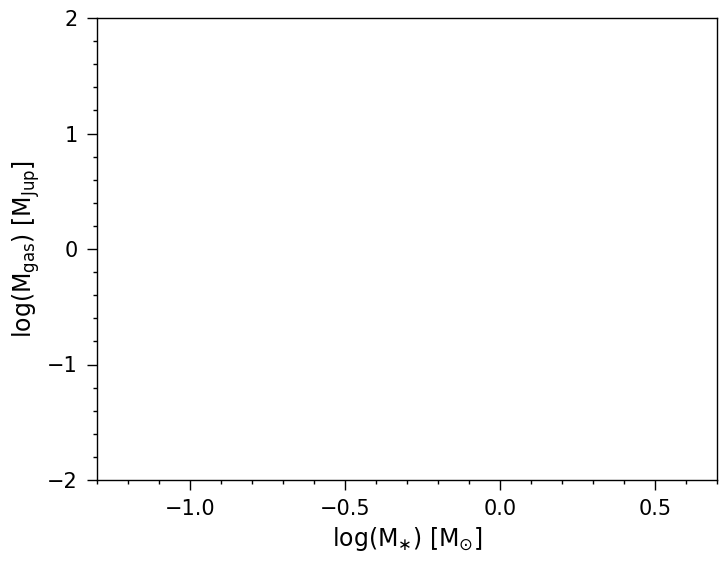

In [6]:
### SETUP PLOT
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)
mpl.rc('xtick.major', size=7, pad=7, width=1)
mpl.rc('ytick.major', size=7, pad=7, width=1)
mpl.rc('axes', linewidth=1)
mpl.rc('lines', markersize=5)
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111)
ax.set_xlim([-1.3, 0.7])
ax.set_ylim([-2.0, 2.0])
ax.yaxis.set_major_locator(MaxNLocator(5, integer=True))
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.set_xlabel(r'$\mathregular{log(M_{\ast})}$' + ' ' + r'$\mathregular{[M_{\odot}]}$', fontsize=17)
ax.set_ylabel(r'$\mathregular{log(M_{gas})}$' + ' ' + r'$\mathregular{[M_{Jup}]}$', fontsize=17)
ax.tick_params(which='minor', axis='x', length=3, color='k', width=1)
ax.tick_params(which='minor', axis='y', length=3, color='k', width=1)
ax.minorticks_on()

In [7]:
### PLOT DATA 
for i, val in enumerate(T['Name']):

    ### PLOT NON-DETECTIONS
    if T['l_Mgas'][i] == '<':
        ax.errorbar(x_data[i], y_data[i], fmt='v', color='lightgray', ms=6, mec='black', mew=0.9, zorder=2)

    ### PLOT DETECTIONS WITH ONLY UPPER LIMITS
    elif T['b_Mgas'][i] is np.ma.masked:
        ax.scatter(x_data[i], y_data[i], marker='o', facecolor='lightblue', s=60, edgecolor='darkslategray', zorder=3, linewidth=1)
        ax.arrow(x_data[i], y_data[i], 0.0, -0.3, head_width=0.02, head_length=0.04, fc='lightgray', ec='lightgray', linewidth=1, zorder=1)
        ax.errorbar(x_data[i], y_data[i], yerr=[[0], [y_max[i] - y_data[i]]], xerr=[x_err[i]],
                    fmt='o', mfc='lightblue', ms=0, mec='black', mew=1, ecolor='lightgray', elinewidth=1, zorder=1, capsize=3)
        
    ### PLOT DETECTIONS WITH BOTH UPPER AND LOWER LIMITS
    else:        
        ax.errorbar(x_data[i], y_data[i], yerr=[[y_data[i] - y_min[i]], [y_max[i] - y_data[i]]], xerr=[x_err[i]],
                    fmt='o', mfc='lightblue', ms=0, mec='black', mew=1, ecolor='lightgray', elinewidth=1, zorder=1, capsize=3)
        ax.scatter(x_data[i], y_data[i], marker='o', facecolor='lightblue', s=60, edgecolor='darkslategray', zorder=3, linewidth=1)

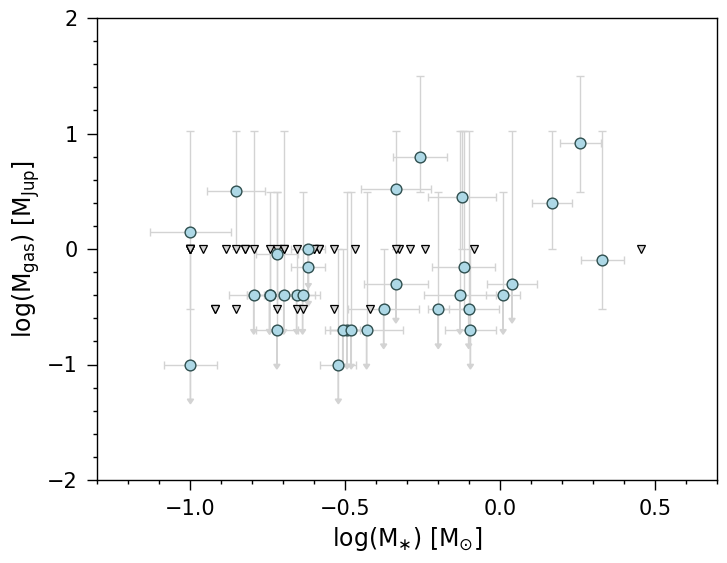

In [8]:
### SAVE FIGURE
fig.savefig('../output/figure_07.png', bbox_inches='tight', dpi=100)
fig

In [9]:
plt.close('all')